# Guided Project: Predicting Bike Rentals

Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

Hadi Fanaee-T at the University of Porto compiled this data into a CSV file, which you'll be working with in this project. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. You can download the data from the University of California, Irvine's website. 

Here are the descriptions for the relevant columns:

<li>instant - A unique sequential ID number for each row
<li>dteday - The date of the rentals
<li>season - The season in which the rentals occurred
<li>yr - The year the rentals occurred
<li>mnth - The month the rentals occurred
<li>hr - The hour the rentals occurred
<li>holiday - Whether or not the day was a holiday
<li>weekday - The day of the week (as a number, 0 to 7)
<li>workingday - Whether or not the day was a working day
<li>weathersit - The weather (as a categorical variable)
<li>temp - The temperature, on a 0-1 scale
<li>atemp - The adjusted temperature
<li>hum - The humidity, on a 0-1 scale
<li>windspeed - The wind speed, on a 0-1 scale
<li>casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
<li>registered - The number of registered riders (people who had already signed up)
<li>cnt - The total number of bike rentals (casual + registered)
In this project, you'll try to predict the total number of bikes people rented in a given hour. You'll predict the cnt column using all of the other columns, except for casual and registered. To accomplish this, you'll create a few different machine learning models and evaluate their performance.

## 1. EDA

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#Use the pandas library to read bike_rental_hour.csv into the dataframe bike_rentals.
bike_rentals=pd.read_csv('bike_rental_hour.csv').copy()
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
#Explore columns
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


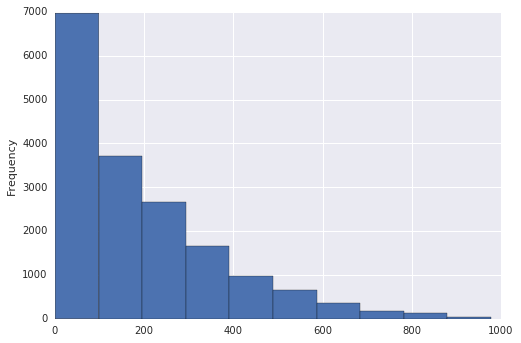

In [4]:
#Make a histogram of the cnt column of bike_rentals, and take a look at the distribution of total rentals.
bike_rentals['cnt'].plot(kind='hist')

In [5]:
#Use the corr method on the bike_rentals dataframe to explore how each column is correlated with cnt.
column_list=bike_rentals.columns.drop(['casual','registered'])
corr_matrix=bike_rentals[column_list].corr()
corr_matrix_cnt=np.abs(corr_matrix['cnt']).sort_values()
corr_matrix_cnt

weekday       0.026900
workingday    0.030284
holiday       0.030927
windspeed     0.093234
mnth          0.120638
weathersit    0.142426
season        0.178056
yr            0.250495
instant       0.278379
hum           0.322911
hr            0.394071
atemp         0.400929
temp          0.404772
cnt           1.000000
Name: cnt, dtype: float64

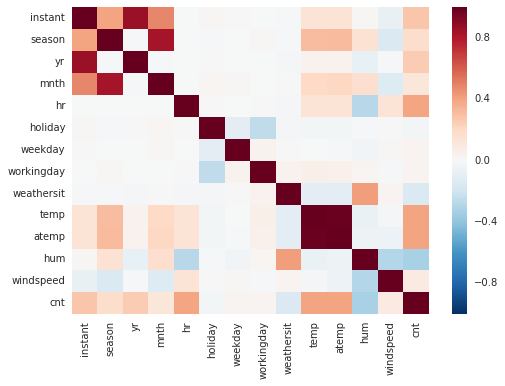

In [6]:
sns.heatmap(corr_matrix)

temp (scaled from 0-1) and atemp (adjusted temp.) are highly correlated to each other. One of these variables seems unecessary and can be omitted. instant is just an ID and can be omitted as well.

# 2. Calculating Features

It can often be helpful to calculate features before applying machine learning models. Features can enhance the accuracy of models by introducing new information, or distilling existing information.

For example, the hr column in bike_rentals contains the hours during which bikes are rented, from 1 to 24. A machine will treat each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column with labels for morning, afternoon, evening, and night. This will bundle similar times together, enabling the model to make better decisions.

In [7]:
#Explore hr column in bike_rentals
bike_rentals['hr'].value_counts().sort_index()

0     726
1     724
2     715
3     697
4     697
5     717
6     725
7     727
8     727
9     727
10    727
11    727
12    728
13    729
14    729
15    729
16    730
17    730
18    728
19    728
20    728
21    728
22    728
23    728
Name: hr, dtype: int64

In [8]:
#Write a function called assign_label that takes in a numeric value for an hour, and returns:
def assign_label(row):
    if row>=6 and row<12:
        return 1
    elif row>=12 and row<18:
        return 2
    elif row>=18 and row<=23:
        return 3
    elif row>=0 and row<6:
        return 4

bike_rentals['time_label']=bike_rentals['hr'].apply(assign_label)
bike_rentals.head(25)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32,4
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13,4
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1,4
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1,4
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2,1
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3,1
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8,1
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14,1


## 3. Splitting the Data into Train and Test Sets

Before you can begin applying machine learning algorithms, you'll need to split the data into training and testing sets. This will enable you to train an algorithm using the training set, and evaluate its accuracy on the testing set. If you train an algorithm on the training data, then evaluate its performance on the same data, you can get an unrealistically low error value, due to overfitting.

<b>ERROR METRIC SELECTION</b>

Q.Based on your explorations of the cnt column, pick an error metric you want to use to evaluate the performance of the machine learning algorithms. Explain why you chose this metric in a markdown cell.

A.Error metric
The mean squared error metric makes the most sense to evaluate our error. MSE works on continuous numeric data, which fits our data quite well. 

In [9]:
#Select 80% of the rows in bike_rentals to be part of the training set using the sample method on bike_rentals. Assign the result to train.
train=bike_rentals.sample(frac=0.8,replace=False,random_state=1)

#Select the rows that are in bike_rentals but not in train to be in the testing set. Assign the result to test.
test=bike_rentals.loc[~bike_rentals.index.isin(train.index)]

## 4. Applying Linear Regression

Now that you've done some exploration and manipulation, you're ready to apply linear regression to the data. Linear regression will probably work fairly well on this data, given that many of the columns are highly correlated with cnt.

As you learned in earlier missions, linear regression works best when predictors are linearly correlated to the target and also independent -- in other words, they don't change meaning when we combine them with each other. The good thing about linear regression is that it's fairly resistant to overfitting because it's straightforward. It also can be prone to underfitting the data, however, and not building a powerful enough model. This means that linear regression usually isn't the most accurate option.

You'll need to ignore the casual and registered columns because cnt is derived from them. If you're trying to predict the number of people who rent bikes in a given hour (cnt), it doesn't make sense that you'd already know casual or registered, because those numbers are added together to get cnt.

The following columns are dropped:
<li>'instant', this is a unique sequential ID number for each row
<li>'casual', see 3rd alinea
<li>'registered', see 3rd alinea
<li>'cnt', this is a target variable, to be predicted
<li>'dteday', we are predicting per hour, not per day 
<li>'temp', see analysis below


The temperature is displayed by two columns: temp (scaled from 0-1) and atemp (adjusted temp.). They are highly correlated to each other. 

- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)

Since a feeling temperature contains more detailed information, I will drop the 'temp' column.

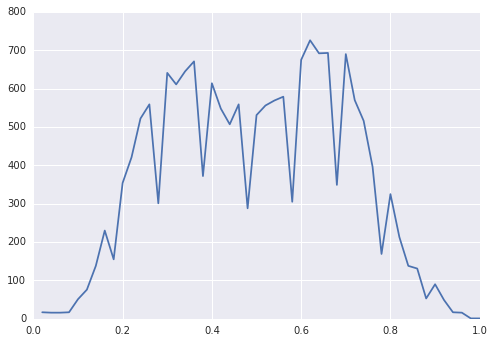

In [10]:
plt.plot(bike_rentals['temp'].value_counts().sort_index())

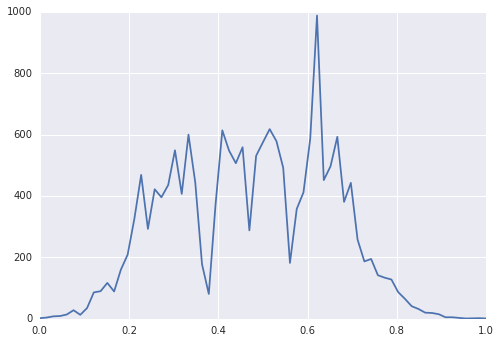

In [11]:
plt.plot(bike_rentals['atemp'].value_counts().sort_index())

In [12]:
#Create a list of predictor columns to use in training and predictions.
features=bike_rentals.columns.drop(['instant','casual','registered','cnt','dteday','temp'])
#features=bike_rentals.columns.drop(['casual','registered','cnt','dteday'])
target='cnt'
features

Index(['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'atemp', 'hum', 'windspeed', 'time_label'],
      dtype='object')

In [13]:
#Use the LinearRegression class from sklearn to train a machine learning algorithm on train.
from sklearn.linear_model import LinearRegression
lr=LinearRegression()
lr.fit(train[features],train[target])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [14]:
#Make predictions using the LinearRegression class on test.
predictions=lr.predict(test[features])

In [15]:
#Calculate the error between the predictions and the actual values.
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(predictions,test[target])
mse

17058.144018902374

In [16]:
np.mean((predictions-test[target])**2)

17058.144018902374

/dataquest/system/env/python3/lib/python3.4/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


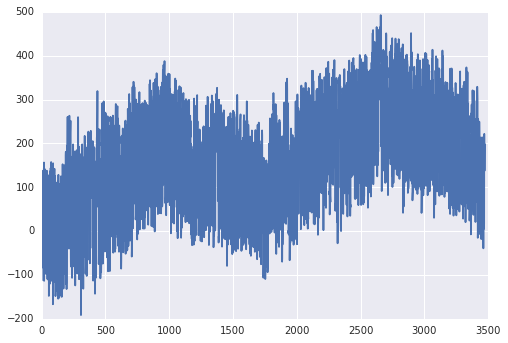

In [17]:
plt.plot(predictions)
plt.legend()
plt.show()

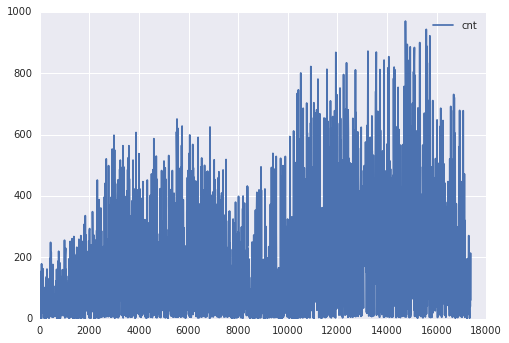

In [18]:
plt.plot(test[target])
plt.legend()
plt.show()

The error is very high, which may be due to the fact that the data has a few extremely high rental counts, but otherwise mostly low counts. Larger errors are penalized more with MSE, which leads to a higher total error.

The Linear Regression predicts negative values, this is not possible in practice. Let's fix this...

In [19]:
test['predictions']=predictions

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [20]:
def adjust_predictions(row):
    if row<0:
        return 0
    else:
        return row

test['predictions_adjusted']=test['predictions'].apply(adjust_predictions)
test.head(25)

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label,predictions,predictions_adjusted
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16,4,-112.251513,0.000000
14,15,2011-01-01,1,0,1,14,0,6,0,2,0.46,0.4545,0.72,0.2836,35,71,106,2,137.825205,137.825205
15,16,2011-01-01,1,0,1,15,0,6,0,2,0.44,0.4394,0.77,0.2985,40,70,110,2,132.297364,132.297364
18,19,2011-01-01,1,0,1,18,0,6,0,3,0.42,0.4242,0.88,0.2537,9,26,35,3,68.631500,68.631500
20,21,2011-01-01,1,0,1,20,0,6,0,2,0.40,0.4091,0.87,0.2537,11,25,36,3,91.021051,91.021051
23,24,2011-01-01,1,0,1,23,0,6,0,2,0.46,0.4545,0.88,0.2985,15,24,39,3,124.557293,124.557293
27,28,2011-01-02,1,0,1,3,0,0,0,2,0.46,0.4545,0.94,0.1940,2,4,6,4,-82.766564,0.000000
29,30,2011-01-02,1,0,1,6,0,0,0,3,0.42,0.4242,0.77,0.2985,0,2,2,1,89.184907,89.184907
30,31,2011-01-02,1,0,1,7,0,0,0,2,0.40,0.4091,0.76,0.1940,0,1,1,1,101.652220,101.652220
31,32,2011-01-02,1,0,1,8,0,0,0,3,0.40,0.4091,0.71,0.2239,0,8,8,1,105.041992,105.041992


In [21]:
np.mean((test['predictions_adjusted']-test[target])**2)

16561.736082565207

## 5. Applying Decision Trees

Now you're ready to apply the decision tree algorithm. You'll be able to compare its error with the error from linear regression, which will enable you to pick the right algorithm for this data set.

Decision trees tend to predict outcomes much more reliably than linear regression models. Because a decision tree is a fairly complex model, it also tends to overfit, particularly when we don't tweak parameters like maximum depth and minimum number of samples per leaf. Decision trees are also prone to instability -- small changes in the input data can result in a very different output model.

In [22]:
#Use the DecisionTreeRegressor class to fit a decision tree algorithm to the train data.
from sklearn.tree import DecisionTreeRegressor
tree=DecisionTreeRegressor(random_state=1,min_samples_leaf=5)
tree.fit(train[features],train[target])

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=1,
           splitter='best')

In [23]:
#Make predictions using the DecisionTreeRegressor class on test.
predictions=tree.predict(test[features])

In [24]:
#Calculate the error between the predictions and the actual values.
np.mean((predictions-test[target])**2)

3031.073411415995

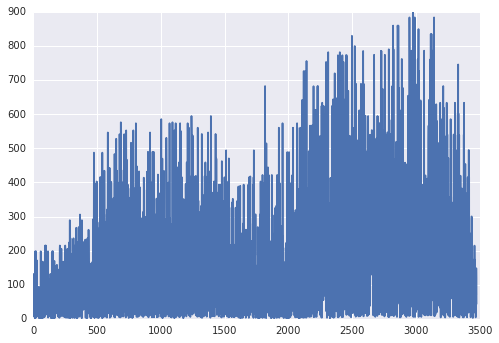

In [25]:
plt.plot(predictions)

In [26]:
#Experiment with various parameters of the DecisionTreeRegressor class, including min_samples_leaf, to see if it changes the error.
mse_list=[]
for i in range(1,13):
    tree=DecisionTreeRegressor(random_state=1,min_samples_leaf=i)
    tree.fit(train[features],train[target])
    predictions=tree.predict(test[features])
    mse=np.mean((predictions-test[target])**2)
    mse_list.append(mse)
mse_list

[3639.307825086306,
 3240.7023398542383,
 3253.467005418105,
 3093.7296844514804,
 3031.073411415995,
 2992.361344247228,
 2846.6342086695518,
 2851.0022989385543,
 2832.1462990251493,
 2892.738059567713,
 2892.333200637348,
 2951.6645123966823]

Decision tree error
By taking the nonlinear predictors into account, the decision tree regressor appears to have much higher accuracy than linear regression. The optimum minimum samples leaf appears to be 9 with a MSE of 2832

## 6. Applying Random Forests

You can now apply the random forest algorithm, which improves on the decision tree algorithm. Random forests tend to be much more accurate than simple models like linear regression. Due to the way random forests are constructed, they tend to overfit much less than decision trees. Random forests can still be prone to overfitting, though, so it's important to tune parameters like maximum depth and minimum samples per leaf.

In [27]:
#Use the RandomForestRegressor class to fit a random forest algorithm to the train data.
from sklearn.ensemble import RandomForestRegressor
forest=RandomForestRegressor(random_state=1,min_samples_leaf=2)
forest.fit(train[features],train[target])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

In [28]:
#Make predictions using the RandomForestRegressor class on test.
predictions=forest.predict(test[features])

In [29]:
#Calculate the error between the predictions and the actual values.
np.mean((predictions-test[target])**2)

2103.180269795196

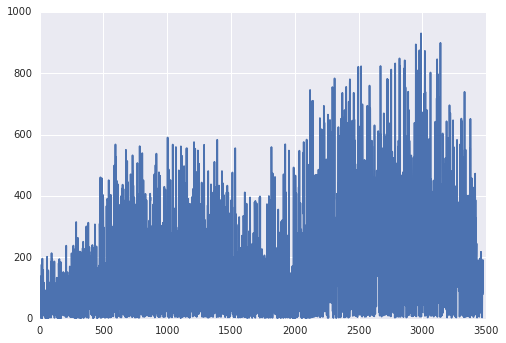

In [30]:
plt.plot(predictions)

In [31]:
#Experiment with various parameters of the RandomForestRegressor class, including min_samples_leaf, to see if it changes the error.
mse_forest_list=[]
for i in range(1,13):
    forest=RandomForestRegressor(random_state=1,min_samples_leaf=i)
    forest.fit(train[features],train[target])
    predictions=forest.predict(test[features])
    mse=np.mean((predictions-test[target])**2)
    mse_forest_list.append(mse)
mse_forest_list

[2180.906968817926,
 2103.180269795196,
 2161.7676016879605,
 2254.8613113896263,
 2329.8538756186927,
 2385.1170927453427,
 2452.245734715903,
 2517.776011197681,
 2610.965631562113,
 2665.2691732366534,
 2740.381995238896,
 2794.7049763824666]

Random forest error
By removing some of the sources of overfitting, the random forest accuracy is improved over the decision tree accuracy. The optimum minimum samples leaf is equal to 2 with a MSE of 2103.
The LinearRegression Model predicts also negative values, while both the DecisionTrees and the Random Forests predicts only positive values.